# Predicting Boston Housing Prices
**by Ronny Restrepo**

The scenario set out for this project is that we are a real estate agency in Boston wanting to have a competitive edge over our rivals. We wish to build our reputation by providing our clients with the best possible estimates for the value of their houses. We will do so by making use of supervised machine learning techniques to create a predictive model of what a house should be worth, given a set of features about the house. Specifically, we will be using a *decision tree*  regression model, and will be training it using a subset of the classic [Boston Housing Dataset](https://archive.ics.uci.edu/ml/datasets/Housing) provided by the *UCI Machine Learning Repository*. This trained model will be used to estimate the value of several houses of hypothetical clients, and it will be evaluated in  terms of its perfromance, predictive power and whether it would be useful to make use of this model in a real world scenario. 

## Setting up the environment

We will be making use of Python's numpy and pandas libraries to handle and explore the data. Matplotlib will be used for plotting and we will import some suplimentary code in a python file visuals.py to generate some plots for visualising the performance of the various models trained under different settings.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import visuals as vs # Supplementary code
from sklearn.cross_validation import ShuffleSplit

# Pretty display for notebooks
%matplotlib inline

## About the data

The dataset that will be used here is a subset of the classic [Boston Housing Dataset](https://archive.ics.uci.edu/ml/datasets/Housing) hosted by the UCI Machine Learning Repository. The data was collected in 1978, from various suburbs in Boston, Massachusetts. Originally it contains 506 entries, each representing an aggregate of houses from the same neighborhood, and is composed of 14 features. However, for the purposes of this project, we will only be making use of the following four features: 

| feature name | description |
| :--- | :--- |
| **RM** | The average number of rooms among homes in the neighborhood. |
| **LSTAT** | The percentage of all Boston homeowners who have a greater net worth than homeowners in the neighborhood. This is an indicator of socio-economic status, with smaller number representing more wealthy areas. A value of 10 represetns that residents in this area are on average amongst the top 10th percent of Boston in terms of income. |
| **PTRATIO** | Is the ratio of students to teachers in primary and secondary schools in the neighborhood. |
| **MEDV** | %  Median value of owner-occupied homes |



Furthermore, the following preoprocessing steps have also been made to the dataset:

- 16 data points have an `'MDEV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The feature `'MDEV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

## Importing the data

We can now import the data from the csv file. 

In [2]:
# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
    
# Success
print "Boston housing dataset has {} data points with {} "\
      "variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


We can see that the preprocessing steps used in creating this data has resulted in slightly less data points than the original data. It has gone from 506 samples to 489 samples. 

We will be using the `'MDEV'` column as the output value we want to predict. We will store this column of data as a variable called `prices`. The remaining columns of data will be used as the predictive variables for the model, and we will store these in a dataframe called `features`.

In [3]:
# Separating input and output features
prices = data['MDEV']
features = data.drop('MDEV', axis = 1)

# Statistical Analysis and Data Exploration

We can perform some basic data exploration to get a better idea about the dataset. We start by looking at the output `prices`.

In [4]:
minimum_price = prices.min()       # Minimum housing value
maximum_price = prices.max()       # Maximum housing value
mean_price = prices.mean()         # Mean house value of the dataset
median_price = prices.median()   # Median house value of the dataset
#std_price = prices.std(ddof=0)      # Biased Estimate of SD
std_price = prices.std(ddof=1)       # Unbiased Estimate of SD

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,340.28


We saw previously that we have just three preditive variables:  

| feature name | description |
| :--- | :--- |
| **RM** | Average number of rooms per house. |
| **LSTAT** | Percentage of all Boston homeowners who have a greater net worth than homeowners in the neighborhood. (indicator of socio-economic status, with a low number indicating high socio-economic status)|
| **PTRATIO** | Pupil-teacher ratio in the neighborhood. |

Intuitively it may be reasonable to assume that there would be a positive correlation between the `'RM'` feature and the the output variable for prices. If we have a region which has on average a greater number of rooms per house, then this may be indicative of bigger homes, which cost more to build, potentially also taking up more landspace. By contrast, it would be reasonable to assume that the other two features `'LSTAT'` and `'PTRATIO'` would have a negative correlation with housing prices in the area. A greater proportion of people from low socio-economic status in an area would indicate that the housing in that area would be more affordable, and have a lower proportion of expensive homes. A high student-teacher ratio would likely occur in a region that does not receive as much funding, indicating that it does not have as many wealthy people in the area, which would likely mean less expensive housing. 

We can explore these assumptions by creating some scatter plots.

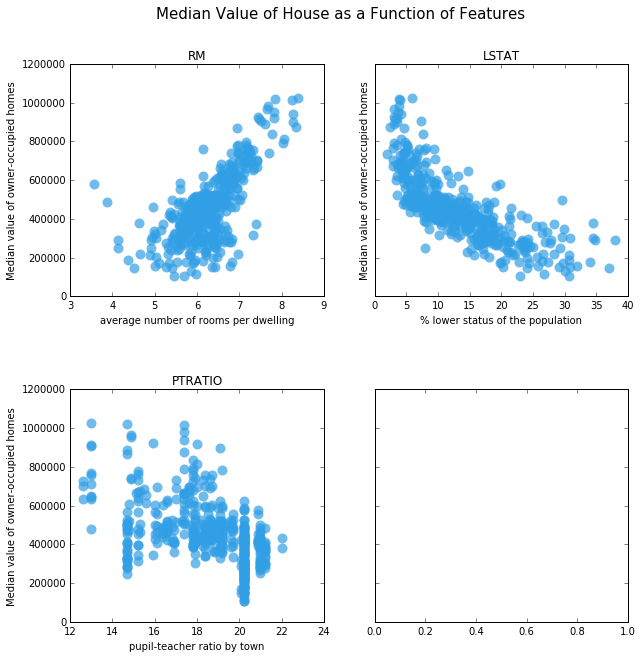

In [5]:
vs.feature_scatterplots(features, prices)

The correlation certainly appears to be quite strong for `'RM'` and `'LSTAT'` precisely in the direction that we had assumed it to be. Our assumption about `'PTRATIO'` also appears to be correct, however it does not appear to be as strongly correlated as the other features are. 

# Creating a Predictive Model

## The Learning Algorithm
The thing we will attempt to make predictions on is house prices. Since houses can take on any value along a continuous scale, this makes it a regression task. For the purposes of this project, we will be making use of a decision tree to create our regression model. 

## Defining a Performance Metric

The process of training a learning algorithhm involves making constant evaluations about what possible options would increase the performance of the model. The metric used to measure performance is in part determined by the type of output data. For instance, if our output data was categorical (ie, membership in some class, like "spam", "not spam"), then we would want a metric that looks at the prpoportions of what things were corectly classified, an what things were incorrectly classified. However, the output data we are dealing with in this task is not of this nature. We are instead dealing with numeric values that are continuous in nature. The values could potentially take one of an infinite number of possible values within some range. `Mean Squared Error` (`MSE`), `Mean Absolute Error` (`MAE`) and `the coefficient of determination` ($R^2$) are common metrics for continuous data. 

We will be making use of $R^2$ for this project. One of the useful features of the $R^2$ metric is that it provides a score that is in an intuitive scale to interpret. The score will usually be within the range from 0 to 1. A model with an $R^2$ score of 1 means that it *always* makes perfect predictions. An $R^2$ score between 0 and 1 represents what percentage of the output variable can be explained by the input features using this model. An $R^2$ score of 0 means that the model is performing no better than if we were to just use the mean of the output variable as our predicted value. Anything less than 0 means that it is performing even worse than just using the mean of the output variable as our predicted value. 

We can now define a function that will calculate our performance metric. 

In [6]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
                             
    # Return the score
    return score

To illustrate how $R^2$ score works, consider the follwing toy model, which makes predictions on five data points. We see in the table below the predicted values, as well as the correct target values. 

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

This toy model demonstrates that it captures the variation of the target variable quite well. The predicted values are within the vicinity of the true expected values. It is not perfect, but it gets quite close most of the time. As such, we should expect an $R^2$ that gets somewhat close to 1. When we run the following code, to get its performance score, we see that this is indeed the case.   

In [7]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


## Splitting data into train/test sets

Before training a It is good practice to split the data into training and test subsets so that we can get a more representative estimate of how well our trained model will actually perform. If we were to evaluate how good our model is using the exact same data that we trained it on, then we would get an overly optimistic estimate. We may end up with a model that does really well at predicting all the training samples, but this may mislead us into thinking that the model will also do well on new data it has never come across. By setting asside a portion of the data to only be used during the evaluation phase, we get a better idea of how good our model will be at making predictions on completely new data. So this way we get a better idea of whether our model generalises well to new data, or if it is overfitting to our training data. Here we will assign 80% of the data to the training set and 20% to the test set. 

It is also a good idea to shuffle the data before splitting. This is to prevent any ordering effects that there may be with the data. For instance, without shuffling, we may end up with certain types of values exclusively appearing in just one of the training or test sets. This could lead to one of two problems. Firstly we could train our model on certain types of data, but we never get to evaluate it on that type of data because it does not appear in the test set. This will give an unrepresentative estimate of the model's performance. Secondly, we could fail to train our model on certain types of data because they just never appear in the training set. This could potentially lead to a very poor model. The ideal situation would be to train the model on data that is as representative as possible. By shuffling the data before splitting, we increase our chances of ensuring that both the training and test sets are both as representative as possible given the available data. 

In [8]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices,
                                                    test_size=0.2, 
                                                    random_state=732)

## Analyzing Model Performance
Before training the actual model we will be using, we will take a look at how model performance is affected by varying sample size and different hyper-paramter values. We will do so by making use of *learning curves* and *complexity curves*. These provides us with important information in a clear visual way that would otherwise remain hidden to us if we we were to rely exclusively on the final output of a grid-search algorithm.

### Learning Curves
Learning curves allow us to see how increasing the number of samples used for training a model can have an effect on its performance. The learning curves below show us the $R^2$ score of the model on both the training and test data for varing sizes of training data. The shaded regions show the the uncertainty  (as a standard deviation) of the $R^2$ estimate. 

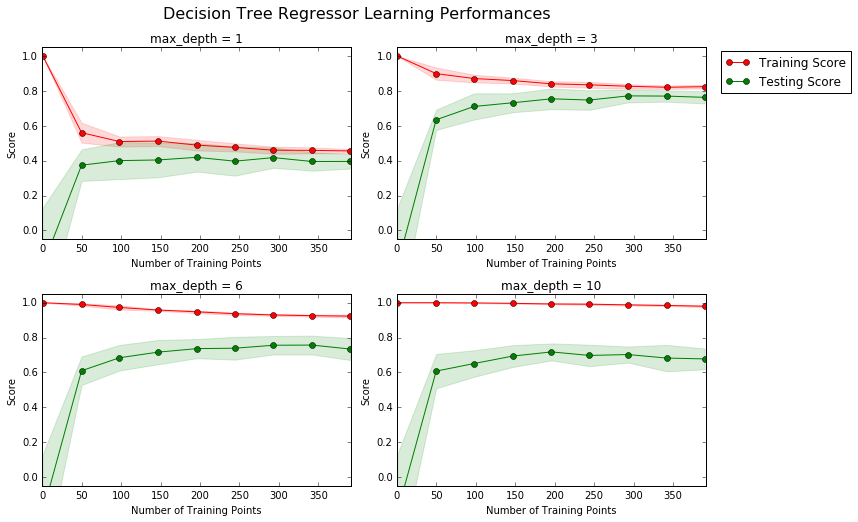

In [9]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

From learning curves above we can see a certain trend between the number of samples and the performance as measured using the training and testing sets. The plot for max depth=3 makes this trend the most visible. We see that if we train using a small sample size, we get get a model that easily overfits to the data, and gives an unrealistically optimistic estimate of its performance when evaluated on the training set data. It is easy to create a model that fits very well to a small number of data points. But this results in a model that does not generalise very well to unseen data. This results in a low $R^2$ score on the testing set. As we use larger and larger sample sizes, it becomes harder to create a model that fits well to all of the data, so the $R^2$ value evaluated on the training data decreases. But, we do get a model that is capable of generalizing better. So we see that the $R^2$ score on the testing data increases. The goal is to create a model where the $R^2$ score performed on the training data and testing data are close to each other. Making use of aditional training data would likely help to close the gap between the performance on training and testing data, hence leading to a better, more generalizable model, though these improvements will likely be quite modest given that the curves have more or less flattened out by the number of data samples already considered.  

### Complexity Curves
Complexity curves allow us to see how increasing the complexity of the model can have an effect on its performance. In the complexity plots below, we see the $R^2$ score performed on both the training and validation sets as a function of the max-depth of the decision tree.

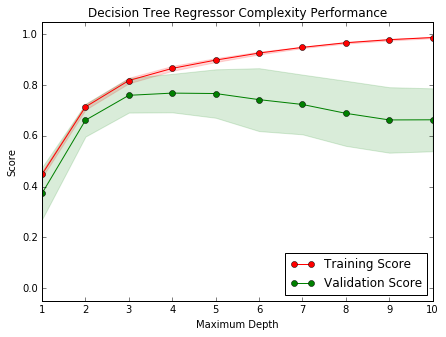

In [10]:
vs.ModelComplexity(X_train, y_train)

If we look at the model created with max_depth=1, we see that the $R^2$ score is quite low for both training and validation data. This is a condition known as *high bias*. Essentially, the model is not paying enough attention to the features in our data. In this case it is creating a model that is too simple to capture the nuances and intricacies of the data.  

If on the other hand we look at the model created with max_depth=10, we see that we have an $R^2$ score on the training data that is quite high, but the score on the validation data is a lot lower. This is a condition known as *high variance*, which means that the model is paying too much attention to the specifics of the training data points. When this is the case, it does not allow the model to generalise as well to new data as would be suggested by the overly optimistic estimate of performance on the training data. In this case, it is creating a model that is too complex.

The model complexity curves show us that as we increase the value for the max depth hyper-parameter, we get a better measure of performance when tested on the training data. This tells us that the model becomes better at describing that data set. But, we also see that the performance improves only up to a certain point and then decreases again when tested on the validation data. What this tells us is that although increasing the max depth appears to improve the performance of the model, there is a point beyond which increasing the max depth no longer has a desirable effect. In fact, it appears to have an undesirable effect once you increase the max depth beyond 4. 

This suggests that increasing the max depth beyond avalue of 4 or 5, will cause our model to overfit. It is becoming too complex, and fitting too well to the specific data points in our training data, but becoming less capable of generalizing to data it was not trained on. So based on this plot, it would appear that the best value for max depth would be about 4. 

## Evaluating Model Performance 

### Grid Search

Different learning algorithms have different settings you can tune. These settings are known as the hyper-parameters of a model. Each one of these hyper-paramters can be thought of as a dial on a dashboard, where we can rotate the dial to get different values. The values (and combination of values) used for these hyper-parameters have an effect on how good the trained model will be. However, it is often a matter of trial and error to find values (or a combination of values) to these hyper-parameters that give the best results. One approach to finding good hyper-parameter values would be to train a model using one set of values, then train again using a different set of values, and continually doing this manually until you find a set of values that works best. A better approach, however, is to use the grid search algorithm. With the grid search algorithm, you specify a list of values you want to explore for each of the hyper-parameters you want to tune. It then trains as many models as needed to explore every single combination of these different values. By storing the performance for each of these models, we can then compare which set of values results in the best model, and we use this to chose the model we want to keep (or just the hyper-parameters that resulted in that model).  

### Cross Validation
In the process of performing a grid search, we need to evaluate and compare different models in order to select which one is the best. It is not a good idea to evaluate each of these models using the test set we put aside previously. The reason for this is that we would in effect be tuning our algorithms to the specifics of that test set. We would essentially be treating that test set as a training set. We would preferably not want to touch that test set until the very end, to make a final, unbiased estimate of the performance of the model. So we need some other way of evaluating each of the models we train in grid search. 

We could just evaluate the model on the exact same data we use to train it with. But this would result in an overly optimistic estimate of performance, and it would give preferential treatment to models that overfit (perform incredibly well on test set, but fail to generalise well on unseen data). 

We could alternatively split the training data even further, into another train/test subset. This would be a better solution, but the problem is that the data used for training becomes smaller and smaller, and we would like to use as much of the data as possible. 

Fortunately there is a technique known as *cross validation* that allows us to train on all of the available training data, while providing a good estimate of how well the model performs on new data. The version of cross validation we will be using is called *k-fold cross validation*. It works in the following way. It starts by splitting the data into a certain number of sections (*folds*). We refer to the number of folds by the number *k*. We start by setting aside one of those folds, and treat it as if it were a test set. The remaining folds are treated as the training data. We then train a model on this train/test subset and evaluate it's performance. We do this k number of times so that all of the folds get a turn at being used as the test set (and the remaining data as the training set). We take the average over the k different estimates of performance, and use this as our actual estimate of what the model should be if we had trained it on the entire training data set. 

This approach is beneficial since it essentially allows us to use the entire training set for training and for evaluation, without as much fear that the estimate of performance is overly tuned to the specific subset of data. In the case of gridsearch, it allows us to make reasonable estimates about which model is indeed the best, not just for the specific training data, but in selecting which one will potentially be the best for making predictions on new data. 

In the next section, we will implement a function that will perform grid search, and cross validation in order to find the best model. 

## Defining the Function to Train our Model

We will define a function called `fit_model`. This function will train a Decision Tree regression model that is estimated to perform best on new data of the same kind. it will do so by implementing the gridsearch algorithm in conjunction with k-fold cross validation to find the best value to max-depth for our model. 

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Tunes a decision tree regressor model using GridSearchCV on the input 
    data X and target labels y and returns this optimal model. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, 
                           random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameters for gridsearch to explore
    params = {'max_depth': np.arange(1,11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid =  GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_


## Training the Model on the Data

Now that we have set everything up it is time to actually train and select the best model. Once trained, we can also probe the model to find out what hyper-parameter values resulted in the best estimated performance. We do this to see whether our previous interpretation of the complexity plots was accurate. 

In [15]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal"\
      "model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimalmodel.


Based on the output, we can see that our interepetation of the complexity plots was correct, exactly. A max depth of 4 is indeed the value that resulted in the best model. 

# Making Predictions

The scenario set out for this project was that we are a real estate agent in the Boston area looking to use machine learning techniques to price homes owned by our clients that wish to sell them. Now that we have a trained model we can actually start to make some predictions of what houses should be worth. 

We have collected the following information from three clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Household net worth (income) | Top 34th percent | Bottom 45th percent | Top 7th percent |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |


Given this set of features, we can make use of our trained model to make predictions about what the house prices for each of the client's homes, and recomend that as the selling price. 

In [16]:
# Produce a matrix for client data
client_data = [[5, 34, 15], # Client 1
               [4, 55, 22], # Client 2
               [8, 7, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, 
                                                                          price)

Predicted selling price for Client 1's home: $339,069.23
Predicted selling price for Client 2's home: $236,451.92
Predicted selling price for Client 3's home: $945,420.00


We saw previously that the range of prices in the dataset ranged from \$105,000 to \$1,024,800. We also saw that ther was a positive corelation between the number of rooms and the price, and a correlation between socio economic status and price. The predictions above seem consistent with the observations we previously made. Client 3, has the most number of rooms, and is of fairly high socio-economic status. The predicted price is consistent with those properties, predicting a very high property value. Client 2 by contrast has the house with the least number of rooms, and of socio-economic status that is within the bottom half of society. The predicted price for this client's home is towards the bottom of the range of house prices. Client 1, has just one more room than client 2, and is of slightly higher socio-economic status, the predicted price is accordingly a little higher. 

# Evaluating Final Model 

We can evaluate wheter or not this trained model should be trusted in a real life scenario. We can start by looking at its performance score. 

In [17]:
train_preds = reg.predict(X_train)
test_preds = reg.predict(X_test)
print "R^2 score for train data is: ", performance_metric(y_train, train_preds)
print "R^2 score for test data is: ", performance_metric(y_test, test_preds)

R^2 score for train data is:  0.866040129548
R^2 score for test data is:  0.842630341575


We can see that this is a fairly good $R^2$ score, and that the model does not *appear* to be overfitting since the score for the test set and the training set are quite close to each other. However, given that it has been created using such a small set of data, it is likely that the model created is not particularly robust. If we were to train on different subsets of the data we may end up with quite different models that make very different predictions. This is something that can occur if the data is noisy and the number of samples used for training is quite small (decision trees in particular are quite vulnerable to this). We can diagnose this if we run the training process multiple times on slightly different subsets of the data, and make predictions using each of the trained models. 

In [18]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $324,240.00
Trial 2: $324,450.00
Trial 3: $346,500.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $344,750.00
Trial 8: $407,232.00
Trial 9: $352,315.38
Trial 10: $316,890.00

Range in prices: $103,732.22


Given the small amount of training data in this dataset, it is dificult to create a model that is robust enough to be reliable. As we can see from the above output, the model fluctuates in its predictions by an order of \$100,000 when trained on slightly different subsets of the data. If we recomended a selling price of \$300,000 for a home that was worth \$400,000 we would lose the trust of our clients quite quickly. Alternatively, if we tried to sell a house for \$400,000 that was truly only worth \$300,000 we would have a dificult time selling it for our clients, again losing their confidence in us. We would need to make use of more datapoints to make better estimates. 

The data itself is also quite old, and may not be representative of the housing market today. Even after adjustment for inflation, there are other factors that may affect the value of homes. Improvements in construction since that time may have resulted in houses that can be built more affordably. So the age of the house may be an important feature that would play a role. 

The data set also does not capture properties at the very top end. The maximum price in our dataset is sligthly over a million dollars. However there are luxury homes in Boston that are worth many millions of dollars. This affects our ability to create a model that would reliably valuate luxury homes. 

Looking at a [heatmap](http://www.trulia.com/real_estate/Boston-Massachusetts/) of actual selling prices in todays market we can see that there tends to be a concentration of more highhly valued properties that are within a certain distance from the city center, and a drop in property values for more distant locations. Distance from a major city is not a feature that is captured in our data. 

This is not to say that our model is useless. It can be used to give us a very rough idea, and can be used to compare which homes *might* be worth more than others. But it should not be used to make reliable property predictions.   